In [55]:
import argparse
import time

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

class AutoDictionary(dict):
    """Implementation of perl's autovivification feature."""
    def __getitem__(self, item):
        try:
            return dict.__getitem__(self, item)
        except KeyError:
            value = self[item] = type(self)()
            return value

name  = "data_"
nodes = ["5653", "55ad", "55e4", "5599", "55dd", "5565", "560b", "5632", "55b3", "5563", "630a"]
#nodes = ["5653"]
ext   = ".csv"

modes_fwd = {"0":"FSK", "1":"OQPSK", "2": "OFDM"}
modes_rev = {"FSK":"0", "OQPSK":"1", "OFDM":"2"}

# Packets per minute
items = len(nodes)
limit = 0

rssi = AutoDictionary()

# Iterate over all nodes
for node in nodes:
    print("Parsing node = {} ".format(node))
    
    # Read values from csv
    filename = name + node + ext
    data = pd.read_csv(filename, index_col=0) 
    
    # Create date column based on day and hour
    data['date'] = data['day'] + ' ' + data['hour']
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
    
    # Drop unnecessary columns
    data = data.drop(['day','hour'], axis=1)
    
    # Set date as index
    data = data.set_index(["date"])
    
    # Per-modulation RSSI
    rssi[node]["FSK"]   = data.groupby(pd.Grouper(freq='D', level='date'))["fsk_rssi"]
    rssi[node]["OQPSK"] = data.groupby(pd.Grouper(freq='D', level='date'))["oqpsk_rssi"]
    rssi[node]["OFDM"]  = data.groupby(pd.Grouper(freq='D', level='date'))["ofdm_rssi"]

Parsing node = 5653 
Parsing node = 55ad 
Parsing node = 55e4 
Parsing node = 5599 
Parsing node = 55dd 
Parsing node = 5565 
Parsing node = 560b 
Parsing node = 5632 
Parsing node = 55b3 
Parsing node = 5563 
Parsing node = 630a 


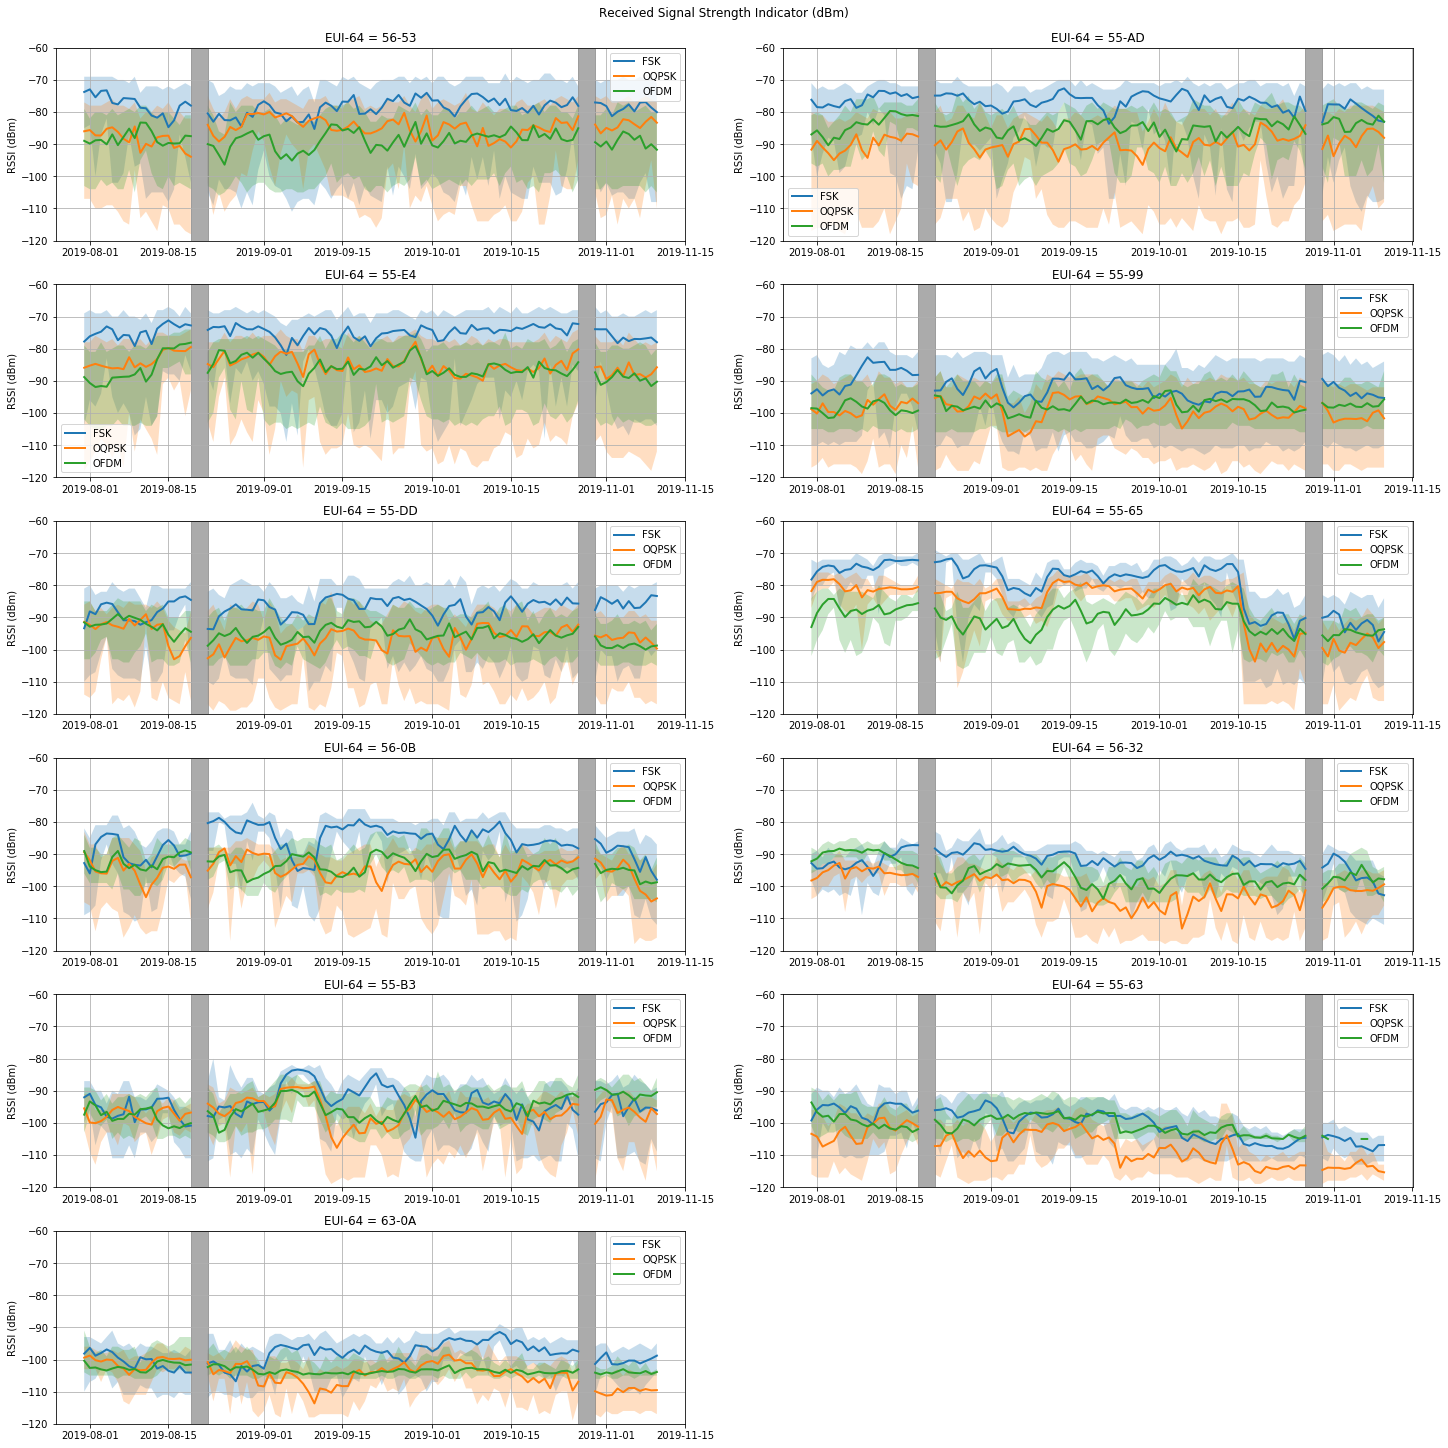

In [56]:
plt.rcParams.update({'errorbar.capsize': 1})

nrow = 6
ncol = 2

fig, axs = plt.subplots(nrow, ncol, figsize=(20,20), constrained_layout=True)

for ax, key in zip(enumerate(fig.axes), rssi.keys()):
    # Recover data
    data_fsk  = rssi[key]["FSK"]
    data_qpsk = rssi[key]["OQPSK"]
    data_ofdm = rssi[key]["OFDM"]
    
    # Recover date
    date = data_fsk.mean().reset_index()['date'].to_numpy()
    
    # Plot FSK
    mean = data_fsk.mean()
    max = data_fsk.max()
    min = data_fsk.min()
    ax[1].plot(date, mean, lw=2, label="FSK")
    ax[1].fill_between(date, min, max, alpha=0.25)
    
    # Plot OQPSK
    mean = data_qpsk.mean()
    max = data_qpsk.max()
    min = data_qpsk.min()
    ax[1].plot(date, mean, lw=2, label="OQPSK")
    ax[1].fill_between(date, min, max, alpha=0.25)
    
    # Plot OFDM
    mean = data_ofdm.mean()
    max = data_ofdm.max()
    min = data_ofdm.min()
    ax[1].plot(date, mean, lw=2, label="OFDM")
    ax[1].fill_between(date, min, max, alpha=0.25)
    
    # Configure plot
    ax[1].legend()
    name = (key[:2] + '-' + key[2:]).upper()
    ax[1].set_title("EUI-64 = {}".format(name))
    ax[1].fmt_xdata = mdates.DateFormatter('%d-%m')
    ax[1].grid()
    ax[1].set_ylim(-120, -60)
    ax[1].set_ylabel("RSSI (dBm)")
    
    ax[1].axvspan(date[19], date[22], alpha=0.66, color='grey')
    ax[1].axvspan(date[88], date[91], alpha=0.66, color='grey')
    #ax[1].autofmt_xdate()
    
fig.delaxes(axs[5][1])
fig.suptitle("Received Signal Strength Indicator (dBm)")
plt.savefig("03_rssi.png", dpi=300)